In [59]:
import numpy as np
import pandas as pd
import re
import nltk
import csv
import pickle

In [122]:
with open('test_data.csv', encoding="utf8", errors='ignore') as f:
      test_data = f.read()


In [99]:
def remove_pattern(input_txt,pattern):
    r=re.findall(pattern,input_txt)
    for i in r:
        input_txt= re.sub(i,'',input_txt)
    return input_txt

In [100]:
test_data['tweet']=np.vectorize(remove_pattern)(test_data['tweet'],"@[\w]*")
test_data['tweet'] = test_data['tweet'].str.replace("[^a-zA-Z#]", " ")
test_data['tweet']=test_data['tweet'].apply (lambda x: ' '.join(r for r in x.split() if len(r)>3))
tokenized_tweet= test_data['tweet'].apply(lambda x: x.split())



In [101]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])  # stemming
tokenized_tweet.head()

0    [imagin, be, girl, have, keep, extra, pair, un...
1              [thi, definit, chick, http, bghsxzvbjx]
2                                                   []
3      [udcfa, collar, caro, mundo, http, rysqu, alnx]
4                 [point, commun, aidant, eatr, invis]
Name: tweet, dtype: object

In [102]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

test_data['tweet'] = tokenized_tweet

In [103]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(test_data['tweet'])

In [104]:
bow

<1893x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 9667 stored elements in Compressed Sparse Row format>

In [105]:
loaded_model = pickle.load(open('finalized_model.sav', 'rb'))

prediction = loaded_model.predict_proba(bow)  # predicting on the validation set
prediction = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction = prediction.astype(np.int)
test_data['predicted_label']=prediction


In [106]:
test_data.to_csv('rf1024.csv', index=False)

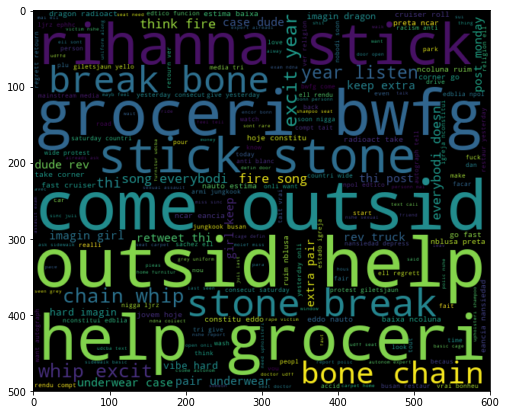

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns

all_words = ' '.join([text for text in test_data['tweet']])
from wordcloud import WordCloud

wordcloud = WordCloud(width=600, height=500, random_state=10, max_font_size=100).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")

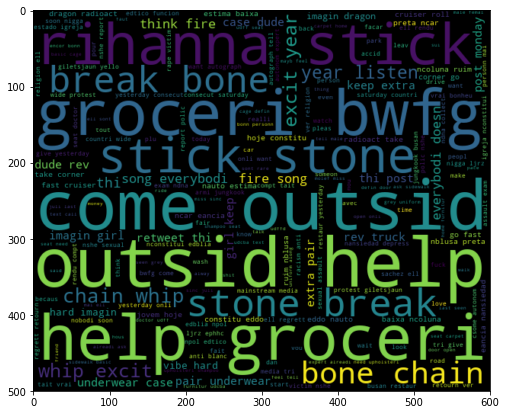

In [108]:
positive_words = ' '.join([text for text in test_data['tweet'][test_data['predicted_label']==0]])

wordcloud = WordCloud(width=600, height=500, random_state=10, max_font_size=100).generate(positive_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")

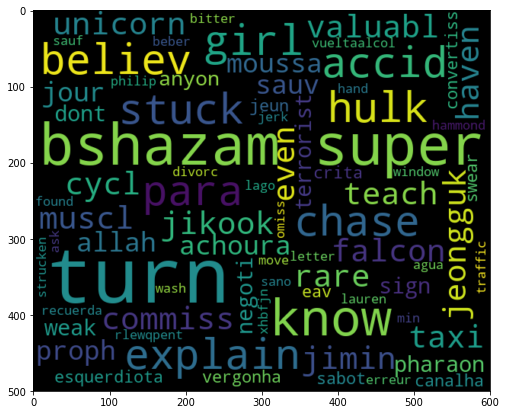

In [109]:
negative_words = ' '.join([text for text in test_data['tweet'][test_data['predicted_label']==1]])

wordcloud = WordCloud(width=600, height=500, random_state=10, max_font_size=100).generate(negative_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")

In [110]:
def hashtag(x):
    hashtags=[]
    for i in x:
        r=re.findall(r'#(\w+)',i)
        hashtags.append(r)
    return hashtags

In [111]:
hashtag_neutral=hashtag(test_data['tweet'][test_data['predicted_label']==0])
hashtag_negative=hashtag(test_data['tweet'][test_data['predicted_label']==1])

In [112]:
hashtag_extract_neutral=sum(hashtag_neutral,[])
hashtag_extract_negative=sum(hashtag_negative,[])


In [113]:
fd_neutral = nltk.FreqDist(hashtag_extract_neutral)
fd_table_neutral = pd.DataFrame({'Hashtag': list(fd_neutral.keys()),
                  'Count': list(fd_neutral.values())})

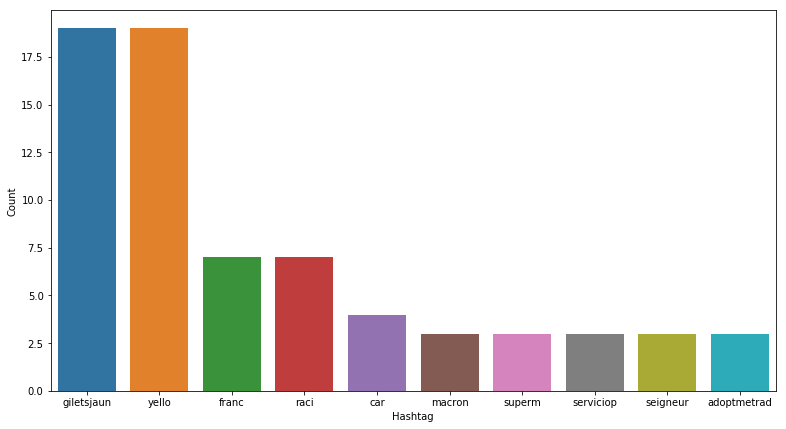

In [114]:
fd_neutral_largest = fd_table_neutral.nlargest(columns="Count", n=10)
plt.figure(figsize=(13, 7))
ax = sns.barplot(data=fd_neutral_largest, x="Hashtag", y="Count")

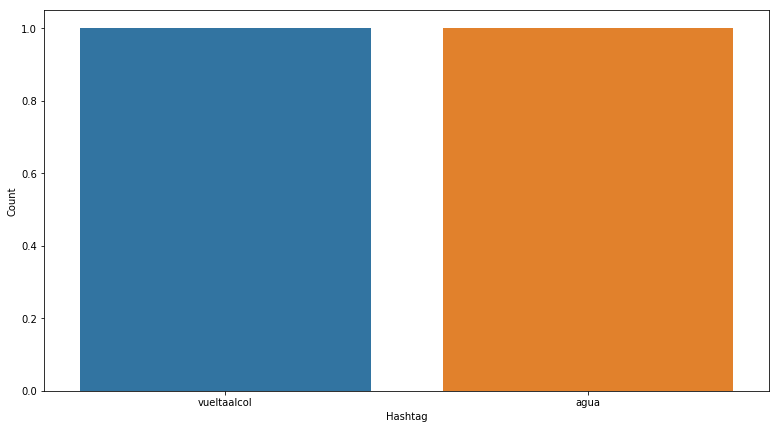

In [115]:
fd_negative = nltk.FreqDist(hashtag_extract_negative)
fd_table_negative = pd.DataFrame({'Hashtag': list(fd_negative.keys()),
                  'Count': list(fd_negative.values())})
fd_negative_largest = fd_table_negative.nlargest(columns="Count", n=10)
plt.figure(figsize=(13, 7))
ax = sns.barplot(data=fd_negative_largest, x="Hashtag", y="Count")